<a href="https://colab.research.google.com/github/UdTatyana/SF-Data-Science/blob/main/EDA-5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://colab.research.google.com/drive/15LoDNrI2lvAbbK7GRX1kP4Ied0EjTVM4#scrollTo=O21G4abe9nIt

# A/B - тестирование

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
ab_data = pd.read_csv('/usr/ab_data.csv') 
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


Итак, мы получили таблицу со следующими полями: user_id идентификатор пользователя, зашедшего на сайт timestamp дата события group группа теста (контрольная или тестовая) converted совершил пользователь целевое действие (нажатие кнопки «добавить в корзину» на сопутствующем товаре) или нет. 1 — да, 0 — нет.

In [ ]:
ab_data.info() # посмотрим тип данных и содержание столбцов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


In [ ]:
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')
# дату переведем в формат datetime

Для того, чтобы получить показатель конверсии в группах на каждый день, нам необходимо предварительно сгруппировать наши данные по дате и группе и вычислить количество пользователей, заходивших на сайт, и суммарное количество совершённых целевых действий.

Дополнительно для удобства сбросим индекс на сгруппированной таблице c помощью метода reset_index() и переименуем столбец user_id в users_count с помощью метода rename().

In [ ]:
daily_data = ab_data.groupby(['timestamp','group']).agg({
    'user_id':'count',
    'converted':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


Для завершения этапа подготовки данных к анализу нам осталось рассчитать конверсию на каждый день проведения A/B-тестирования. Напомним: ежедневная конверсия рассчитывается как отношение числа посетителей сайта, выполнивших на нём какие-либо целевые действия в день, к ежедневному общему числу посетителей сайта, умноженная на 100 %

In [ ]:
daily_data['conversion'] = (daily_data['converted'] / daily_data['users_count']) * 100
daily_data.head()

,timestamp,group,users_count,converted,conversion
0,2017-01-02,A,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063
3,2017-01-03,B,6620,754,11.389728
4,2017-01-04,A,6573,797,12.125361


Задание 4.1

Чему была равна конверсия (в процентах) в группе А 5 января 2017 года? Ответ округлите до второго знака после запятой

In [ ]:
mask = (daily_data['timestamp'] == '2017-01-05') & (daily_data['group'] == 'A')
round(daily_data[mask]['conversion'], 2)

6    12.32
Name: conversion, dtype: float64

# Визуальный анализ конверсии в группах

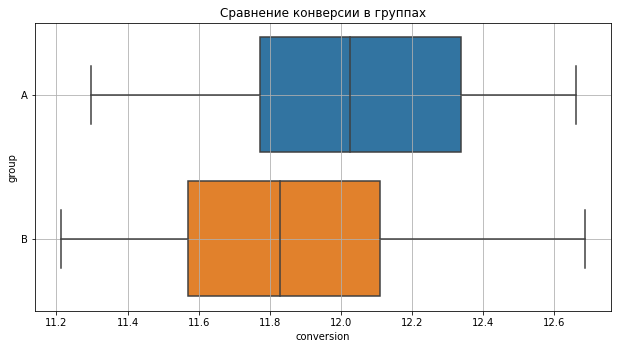

In [ ]:
fig = plt.figure(figsize=(8, 4)) # создаём фигуру размером 8x4
ax = fig.add_axes([1, 1, 1, 1]) # добавляем систему координат 
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax) # строим boxplot для conversion по признаку group 
ax.set_title('Сравнение конверсии в группах') # задаём подпись к графику
ax.grid() # задаём отображение сетки

Что можно сказать исходя из этого графика? Во-первых, медианное значение ежедневной конверсии в группе А, выше, чем в группе B. Во-вторых, разброс конверсии в группе B несколько больше, чем в группе A.

Примечание. Прежде чем делать выводы по визуальному представлению данных, всегда обращайте внимание на численные значения показателей. Они могут различаться в масштабе графика, но на практике разница между ними не будет иметь значения. Также всегда стоит убедиться, что в данных нет выбросов (базовый вариант — сравнить медиану и среднее между собой). Далее мы ещё поговорим о стабилизации показателя во времени.

In [ ]:
# вычислим среднее и медианное значение для каждой группы
conversion_piv = daily_data.groupby('group')['conversion'].agg(
    ['mean', 'median']
)
display(conversion_piv)

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


Из полученной таблицы видно, что медиана и среднее в каждой группе практически совпадают. При этом разница между показателями в группах менее 0.3 %

Посмотрим на кумулятивные метрики

In [ ]:
# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_converted']/daily_data['cum_users_count'] * 100
display(daily_data.head())

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806


А теперь построим графики кумулятивной конверсии по дням в каждой группе:

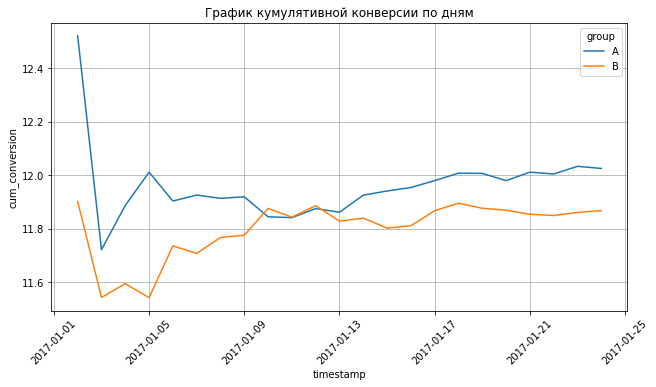

In [ ]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='timestamp', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True)

До 2017-01-09 конверсия была нестабильна, но после 2017-11-01 резкие скачки прекратились (кривая графика переходит в прямую). Судя по графику, конверсия группы B стабильно хуже конверсии группы А на всём промежутке времени. На основании стабилизированного кумулятивного графика мы можем сделать вывод, что длительность эксперимента была достаточной для того, чтобы судить о статистической значимости разности между показателем конверсии в группах.

## Задание 4.6

Проводится A/B-тестирование для двух вариантов дизайна сайта. Результаты тестирования собраны в двух файлах (данные для группы А и для группы B). Каждая таблица имеет следующие поля: date — дата наблюдения; cid — идентификатор посетителя; transactions — количество совершённых целевых действий (транзакций); revenue — сумма покупки; group — группа (тестовая — А, контрольная — B). Постройте таблицу со следующими ежедневными показателями: количество посетителей сайта; суммарное число транзакций; общая сумма покупок (выручка). Для этого сгруппируйте данные по признаку date, предварительно преобразовав его к типу datetime. Чему равны значения ежедневных показателей в группе А на 8 ноября 2020 года? Количество посетителей сайта

In [ ]:
a = pd.read_csv('/ab_test-redesign_sample_a.csv')
b = pd.read_csv('/ab_test-redesign_sample_b.csv')

a['date'] = pd.to_datetime(a['date'])
b['date'] = pd.to_datetime(b['date'])

a = a.groupby(['date']).agg({ # группировка по дате
    'cid':'count', # метод agg() - д/группировки с агрегациями, в него передаем словарь, 
    'transactions':'sum', # где ключ - имя столбца - название агрегатной функции
    'revenue':'sum'
}).reset_index() # сброс индексов

b = b.groupby(['date']).agg({
    'cid':'count',
    'transactions':'sum',
    'revenue':'sum'
}).reset_index()

a[a['date'] == '2020-11-08']

,date,cid,transactions,revenue
2,2020-11-08,3354,25,846051


## Задание 4.7

Добавьте в каждую из таблиц кумулятивные метрики: кумулятивное количество посетителей сайта; кумулятивное суммарное число транзакций; кумулятивная общая сумма покупок (кумулятивная выручка).

Рассчитайте кумулятивную конверсию действия покупки (в процентах) и кумулятивный средний чек (кумулятивная выручка/кумулятивное суммарное число транзакций).

Чему равна средняя кумулятивная конверсия в группах за весь период проведения A/B-теста? Ответ округлите до сотых, знаки процентов не вводите.

In [ ]:
# Для группы А
# кумулятивное количество посетителей:
a['cum_cid'] = a['cid'].cumsum() 
# кумулятивное число транзакций:
a['cum_transactions'] = a['transactions'].cumsum()
# кумулятивная выручка:
a['cum_revenue'] = a['revenue'].cumsum()
# кумулятивная конверсия действия покупки (в %):
a['cum_buy'] = a['cum_transactions'] / a['cum_cid'] * 100
# кумулятивный средний чек:
a['cum_avg_check'] = a['cum_revenue'] / a['cum_transactions']
# кумулятивная конверсия:
a['cum_conversion'] = a['cum_transactions']/a['cum_cid']*100

print('Средняя кумулятивная конверсия в группе А:', round(a['cum_conversion'].mean(), 2))

# Для группы В
# кумулятивное количество посетителей:
b['cum_cid'] = b['cid'].cumsum()
# кумулятивное число транзакций:
b['cum_transactions'] = b['transactions'].cumsum()
# кумулятивная выручка:
b['cum_revenue'] = b['revenue'].cumsum()

# кумулятивная конверсия действия покупки (в %):
b['cum_buy'] = b['cum_transactions'] / b['cum_cid'] * 100
# кумулятивный средний чек:
b['cum_avg_check'] = b['cum_revenue'] / b['cum_transactions']
# кумулятивная конверсия:
b['cum_conversion'] = b['cum_transactions']/ b['cum_cid']*100

print('Средняя кумулятивная конверсия в группе B:', round(b['cum_conversion'].mean(), 2))

Средняя кумулятивная конверсия в группе А: 0.71
Средняя кумулятивная конверсия в группе B: 0.76


## Задание 4.8
Постройте графики кумулятивной конверсии в каждой группе. Какие выводы по ним вы можете сделать?
1. Конверсия в группе B стабильно выше конверсии в группе A на всём промежутке времени.
2. С уверенностью можно сказать, что, если продолжить тест, конверсия в группе A будет выше конверсии в группе B.
3. Начиная с 9 ноября 2020 года конверсии в группах имеют приблизительно идентичное поведение (одинаковые точки роста и спада). При этом конверсия в группе B стабильно выше конверсии в группе A на данном периоде.
4. Никаких выводов сделать нельзя.

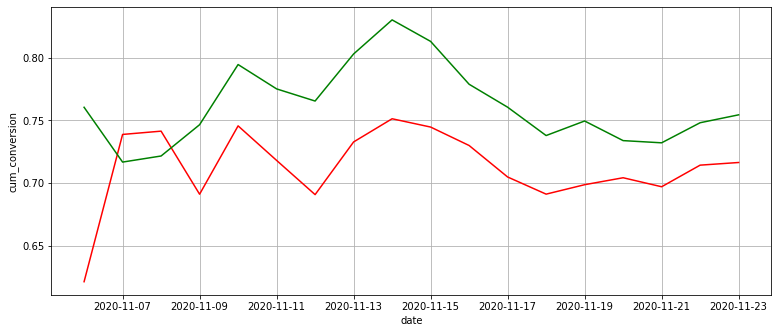

In [ ]:
fig = plt.figure(figsize=(10, 4)) # фигура
ax = fig.add_axes([1, 1, 1, 1]) # система координат
sns.lineplot(x='date', y='cum_conversion', data=a, color='red')
sns.lineplot(x='date', y='cum_conversion', data=b, color='green')
ax.grid(True)

## Задание 4.9
Постройте графики кумулятивного среднего чека в каждой группе. Какие выводы по ним вы можете сделать?
1. Средний чек в группе B стабильно выше среднего чека в группе A на всём промежутке времени.
2. В начале периода наблюдения средний чек в группе B был меньше, чем средний чек в группе A. Однако при стабилизации метрик наблюдается обратный результат.
3. В начале периода наблюдения средний чек в группе A был меньше, чем средний чек в группе B. Однако при стабилизации метрик наблюдается обратный результат.
4. Никаких выводов сделать нельзя.

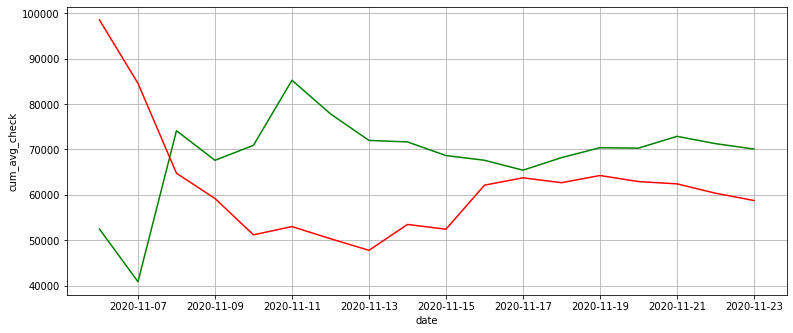

In [ ]:
fig = plt.figure(figsize=(10, 4)) # фигура
ax = fig.add_axes([1, 1, 1, 1]) # система координат
sns.lineplot(x='date', y='cum_avg_check', data=a, color='red')
sns.lineplot(x='date', y='cum_avg_check', data=b, color='green')
ax.grid(True)

-----

# Анализ результатов А/В-тестирования: 
# Статистические тесты 

## Для конверсии

In [ ]:
from statsmodels.stats.proportion import proportions_ztest # импорт функции

In [ ]:
# вычислим количество успехов и общее количество наблюдений для передачи в функцию
converted = ab_data.groupby('group')['converted'].agg( 
    ['sum', 'count']
)
display(converted)

,sum,count
group,,
A,17467,145241
B,17238,145241


In [ ]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted['sum'], #число "успехов"
    nobs=converted['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.1
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


## Статистические тесты для других метрик

In [ ]:
data = pd.read_excel('/time_data.xlsx')
data.head()

,time(A),time(B)
0,435.0,549.2
1,454.5,630.2
2,447.0,437.2
3,480.0,637.2
4,561.0,712.4


Построим гистограмму времени, проведённом пользователями на сайте в каждой из групп:

Text(0.5, 1.0, 'Распределение времени на сайте в группе B')

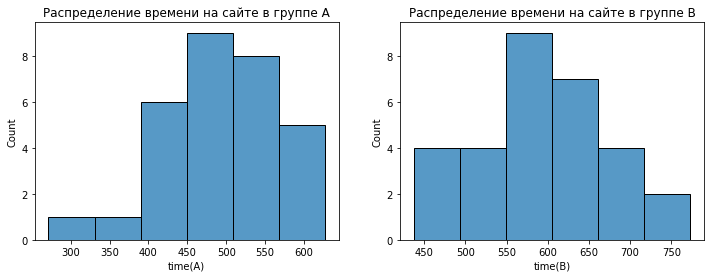

In [ ]:
#создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='time(A)', data=data, ax=axes[0])
sns.histplot(x='time(B)', data=data, ax=axes[1])
#задаём названия графикам
axes[0].set_title('Распределение времени на сайте в группе А')
axes[1].set_title('Распределение времени на сайте в группе B')

Гистограммы напоминают нормальное распределение. Проверим гипотезу о нормальности обоих распределений с помощью критерия Шапиро-Уилка.

In [ ]:
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы:
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(data['time(A)'])
shapiro_result_b = shapiro(data['time(B)'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.43
p-value группы B 0.12
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


Распределение в обеих группах нормальное, а значит, можно воспользоваться T-тестом для того, чтобы сравнить среднее время посещения сайта в группах.

In [ ]:
from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы:
H0 = 'Среднее время в группах одинаково'
H1 = 'Среднее время в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=data['time(A)'],
    b=data['time(B)'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу
Альтернативная гипотеза. H1: Среднее время в группе А меньше, чем в группе B


## Задание 5.2
Проверьте гипотезу о равенстве конверсий в группах А и B при альтернативной гипотезе: Конверсия в группе А меньше, чем конверсия в группе B. Используйте функцию proportions_ztest() из модуля statsmodels.stats.proportion. В качестве уровня значимости возьмите 0.1
Каковы результаты тестирования?
1. Конверсия в группе А больше, чем конверсия в группе B
2. Конверсия в группе А меньше, чем конверсия в группе B
3. Конверсии в группах равны
4. Ничего сказать нельзя

In [ ]:
from statsmodels.stats.proportion import proportions_ztest # импорт функции

a = pd.read_csv('/content/ab_test-redesign_sample_a.csv')
b = pd.read_csv('/content/ab_test-redesign_sample_b.csv')

a['date'] = pd.to_datetime(a['date'])
b['date'] = pd.to_datetime(b['date'])

# объединим датафреймы
a_b = pd.concat([a, b])

# вычислим количество успехов и общее количество наблюдений для передачи в функцию
converted_a_b = a_b.groupby('group')['transactions', 'cid'].agg('sum')

H0 = 'Конверсии в группах А и B равны' # нулевая гипотеза
H1 = 'Конверсия в группе А меньше, чем конверсия в группе В' # альтернативная гипотеза - левосторонняя
alpha = 0.1 # уровень значимости

_, p_value = proportions_ztest(
    count=converted_a_b['transactions'], #число "успехов"
    nobs=converted_a_b['cid'], #общее число наблюдений
    alternative='smaller',
)

print('p-value: ', round(p_value, 2)) # выводим p-value 

if (p_value < alpha): # сравниваем полученное p-value с уровнем значимости
    print("Отвергаем нулевую гипотезу. {}")
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.22
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]


## Задание 5.3
Проверьте гипотезу о нормальности распределений ежедневного среднего чека с помощью критерия Шапиро-Уилка. В качестве уровня значимости возьмите 0.1
Каковы результаты тестирования?
1. Распределения в обеих группах являются нормальными
2. Распределение в одной или обеих группах отличны от нормального

In [ ]:
from scipy.stats import shapiro

daily_bill_mean_a = a.groupby('date')['revenue'].agg('mean') # ежедневный средний чек
daily_bill_mean_b = b.groupby('date')['revenue'].agg('mean')

H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.1 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_a = shapiro(daily_bill_mean_a)
shapiro_b = shapiro(daily_bill_mean_b)
print('p-value группы А', round(shapiro_a.pvalue, 2))
print('p-value группы B', round(shapiro_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_a.pvalue < alpha or shapiro_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу.")
    print("Альтернативная гипотеза H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))


p-value группы А 0.01
p-value группы B 0.15
Отвергаем нулевую гипотезу.
Альтернативная гипотеза H1: Распределение в одной или обеих группах отлично от нормального


## Задание 5.4
Проверьте гипотезу о равенстве ежедневных средних чеков с помощью критерия Манна-Уитни при альтернативной гипотезе: Ежедневный средний чек в группе А меньше, чем в группе B. Используйте функцию mannwhitneyu() из модуля scipy.stats. В качестве уровня значимости возьмите 0.1
Каковы результаты тестирования?
1. Средние чеки в группах А и B равны
2. Ежедневный средний чек в группе А меньше, чем в группе B
3. Ежедневный средний чек в группе А больше, чем в группе B
4. Никаких выводов сделать нельзя

In [ ]:
H0 = 'Ежедневные средние чеки в группах равны' # нулевая гипотеза
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B' # альтернативная гипотеза - левосторонняя
alpha = 0.1 # уровень значимости

from scipy.stats import mannwhitneyu # импорт функции

_, pvalue = mannwhitneyu(
    daily_bill_mean_a,
    daily_bill_mean_b,
    alternative='less'
)
# выведем значение pvalue
print('pvalue =', round(pvalue, 2))

if pvalue < alpha:
  print(f'Отвергаем нулевую гипотезу. {H1}')
else:
  print(f'Принимаем нулевую гипотезу. {H0}')

pvalue = 0.07
Отвергаем нулевую гипотезу. Ежедневный средний чек в группе А меньше, чем в группе B


# Доверительные интервалы

# Доверительный интервал для среднего при известном истинном стандартном отклонении

Была опрошена случайная выборка из 36 жителей региона об их затратах на продукты питания за последний месяц. Выборочное среднее оказалось равным 16 100 рублей.
Допустим, откуда-то известно, что истинное стандартное отклонение расходов равно 12 000 рублей.
Нам нужно построить доверительный интервал для истинных средних расходов жителя данного региона на продукты питания в месяц. Интервал должен определять истинное значение с надежностью в 95 %.

In [ ]:
n = 36 # размер выборки
x_mean = 16100 # выборочное среднее
sigma = 12000 # истинное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

from scipy.stats import norm
z_crit = -norm.ppf(alpha/2) # z критическое

eps = z_crit * sigma/(n ** 0.5) #погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал: (12180, 20020)


### Задание 6.5
Аккумуляторный завод производит батарейки, срок службы которых имеет истинное стандартное отклонение в 2.4 месяца. Средний срок службы батареек в случайной выборке из 64 штук составил 12.35 месяца. Необходимо построить 90 %-ный доверительный интервал для истинного среднего срока службы производимой батарейки и ответить на вопросы заданий ниже.

In [ ]:
n = 64
x_mean = 12.35
sigma = 2.4
gamma = 0.9
alpha = 1 - gamma

z_crit = round(-norm.ppf(alpha/2), 2)

eps = z_crit * sigma/(n ** 0.5) #погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound, 2), round(upper_bound, 2)) # создаём кортеж из округлённых границ интервала
print('z-критическое:', z_crit)
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

z-критическое: 1.64
Доверительный интервал: (11.86, 12.84)


# Доверительный интервал для среднего при неизвестном стандартном отклонении

Управляющий супермаркета хочет оценить, сколько денег покупатели тратят за один поход в супермаркет в среднем. На основании ранее собранных данных известно, что расходы одного покупателя распределены приблизительно нормально. Управляющий взял случайную выборку из 15 покупателей и выяснил, что их средние расходы равны 2 000 рублей, а выборочное стандартное отклонение равно 400 рублей.

In [ ]:
n = 15 # размер выборки
k = n - 1 # число степеней свободы
x_mean = 2000 # выборочное среднее
x_std = 400 # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

from scipy.stats import t
t_crit = -t.ppf(alpha/2, k) # t-критическое

eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал: (1778, 2222)


## Задание 6.6
Чиновника интересует сумма подоходного налога, выплачиваемого домохозяйствами за год. На случайной выборке из 25 домохозяйств был посчитан средний размер выплаченного налога, и он составил 3540. Также известно выборочное отклонение величины подоходного налога, равное $ 1 150.
Необходимо найти 90 %-ый доверительный интервал для истинного среднего значения налоговых выплат за год. Используйте формулу с t-критическим.
Укажите границы построенного доверительного интервала для истинного среднего. Ответ округлите до целого.

In [ ]:
n = 25 # размер выборки
k = n - 1 # число степеней свободы
x_mean = 3540 # выборочное среднее
x_std = 1150 # выборочное стандартное отклонение
gamma = 0.9 # уровень надёжности
alpha = 1 - gamma # уровень значимости

from scipy.stats import t
t_crit = -t.ppf(alpha/2, k) # t-критическое

eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал: (3146, 3934)


# Доверительный интервал для пропорции (конверсия, доля, любой бинарный признак)

In [ ]:
# универсальная функция:
def proportions_conf_interval(n, x_p, gamma=0.95): 
  # n - размер выборки, х_р - выборочная пропорция, gamma - уровень надежности 
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [ ]:
import pandas as pd
ab_data = pd.read_csv('/content/ab_data.csv')

#фильтруем данные группы А
a_data = ab_data[ab_data['group'] == 'A']
#фильтруем данные группы B
b_data = ab_data[ab_data['group'] == 'B']

conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['converted'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['converted'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.86, 12.19)
Доверительный интервал для конверсии группы B: (11.7, 12.03)


# Доверительный интервал разницы пропорций

Для чего нужен? Вывод по результату:
* обе границы больше 0: вариант В эффективнее по метрике конверсии с заданной надежностью
* обе границы меньше 0: вариант В хуже
* интервал охватывает 0: варианты А и В равнозначны

In [ ]:
    # универсальная функция:
    def diff_proportions_conf_interval(n, xp, gamma=0.95):
      # n-размер выборки, хр-список из выборочных пропорций для групп А и B соответственно
        alpha = 1 - gamma # уровень значимости
        diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
        z_crit = -norm.ppf(alpha/2) # z критическое
        eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
        lower_bound = diff - eps # левая (нижняя) граница
        upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
        return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [ ]:
# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['converted'].mean(), b_data['converted'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.39, 0.08)


Отсюда можно сделать вывод, что статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.

## Задание 6.9
Чтобы оценить удовлетворённость клиентов сети отелей, менеджер взял случайную выборку из 189 комментариев, оставленных посетителями на онлайн-платформе по бронированию, и провёл анализ их содержания. Выяснилось, что 132 комментария были положительными, остальные — негативными.
Давайте поможем менеджеру ответить на несколько вопросов!
Чему равна выборочная пропорция положительных комментариев? Укажите с точностью до трёх знаков после разделительной точки.
Найдите 90 % доверительный интервал для истинной пропорции положительных комментариев. Ответ приведите в процентах и округлите до двух знаков после запятой. При расчёте используйте z-критическое.

In [ ]:
conf_internal = proportions_conf_interval(
    n = 189,
    x_p = 132/189,
    gamma = 0.9
)
print('Выборочная пропорция положительных комментариев:', round(132/189, 3))
print('Доверительный интервал:', conf_internal)

Выборочная пропорция положительных комментариев: 0.698
Доверительный интервал: (64.35, 75.33)


## Задание 6.10
Проводится A/B-тестирование вариантов отображения страницы корзины на сайте интернет-магазина. Есть два варианта отображения страницы: с товарными рекомендациями «Хиты продаж» и персональными, подобранными под интерес конкретно этого пользователя. Метрикой является конверсия действия «добавить в корзину товар из рекомендаций». Были собраны следующие данные:
Группа А(Персональные скидки): Число добавленных в корзину товаров - 45; Размер выборки - 1000
Группа В(Хиты продаж): Число добавленных в корзину товаров - 50; Размер выборки - 1000.

Постройте 95 %-ый доверительный интервал разности полученных конверсий. Ответ приведите в процентах и округлите границы интервала до второго знака после запятой. При расчёте используйте z-критическое.
Какой вывод можно сделать на основе полученного доверительного интервала?
1. вариант А является более предпочтительным варианту B по показателю конверсии
2. вариант B является более предпочтительным варианту А по показателю конверсии
3. варианты А и B равнозначны по показателю конверсии

In [ ]:
n = [1000, 1000] # размеры выборок
xp = [(45/1000), (50/1000)] # выборочные пропорции

diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал разности конверсий:', diff_inverval)

if diff_inverval[0] > 0 and diff_inverval[1] > 0:
  print('вариант B является более предпочтительным варианту А по показателю конверсии')
elif diff_inverval[0] < 0 and diff_inverval[1] < 0:
  print('вариант А является более предпочтительным варианту B по показателю конверсии')
else:
  print('варианты А и B равнозначны по показателю конверсии')

Доверительный интервал разности конверсий: (-1.36, 2.36)
варианты А и B равнозначны по показателю конверсии
